https://www.kaggle.com/c/freesound-audio-tagging-2019/discussion/89108#latest-529449

In [1]:
import os
import wave
import shutil
import librosa
import pathlib
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd  # To play sound in the notebook
import seaborn as sns
import pickle
from scipy.io import wavfile

%matplotlib inline
matplotlib.style.use('ggplot')

### Loading data

In [2]:
data_dir = '../data/input/'
train_curated = pd.read_csv(data_dir + 'train_curated.csv')
train_noisy = pd.read_csv(data_dir + 'train_noisy.csv')
test = pd.read_csv(data_dir + 'sample_submission.csv')

In [3]:
train_curated["nframe"] = train_curated["fname"].apply(
    lambda f: wave.open(data_dir + "train_curated/" + f).getnframes()
)
train_noisy["nframe"] = train_noisy["fname"].apply(
    lambda f: wave.open(data_dir + "train_noisy/" + f).getnframes()
)
test["nframe"] = test["fname"].apply(
    lambda f: wave.open(data_dir + "test/" + f).getnframes()
)

In [10]:
train_curated["wav_data_std"] = train_curated["fname"].apply(
    lambda f: wavfile.read(data_dir + "train_curated/" + f)[1].std()
)
train_noisy["wav_data_std"] = train_noisy["fname"].apply(
    lambda f: wavfile.read(data_dir + "train_noisy/" + f)[1].std()
)
test["wav_data_std"] = test["fname"].apply(
    lambda f: wavfile.read(data_dir + "test/" + f)[1].std()
)

In [14]:
train = pd.concat([train_curated, train_noisy], axis=0, sort=False, ignore_index=True)
train['noisy_flg'] = 0
train.loc[len(train_curated):len(train_curated) + len(train_noisy), 'noisy_flg'] = 1
train['n_labels'] = train['labels'].apply(lambda x: len(x.split(',')))

total = pd.concat([train, test[['fname', 'nframe']]], axis=0, sort=False, ignore_index=True)
total['test_flg'] = 0
total.loc[len(train):len(train) + len(test), 'test_flg'] = 1
total.head()

,fname,labels,nframe,wav_data_std,noisy_flg,n_labels,test_flg
0,0006ae4e.wav,Bark,310456,407.965955,0.0,1.0,0
1,0019ef41.wav,Raindrop,90616,75.109294,0.0,1.0,0
2,001ec0ad.wav,Finger_snapping,66976,334.738651,0.0,1.0,0
3,0026c7cb.wav,Run,1125886,581.425611,0.0,1.0,0
4,0026f116.wav,Finger_snapping,60638,649.458686,0.0,1.0,0


### train_curated

In [15]:
train_curated.query("wav_data_std == 0")

,fname,labels,nframe,wav_data_std
534,1d44b0bd.wav,Whispering,623616,0.0


1d44b0bd.wav
../data/input/train_curated/


,fname,labels,nframe,wav_data_std,noisy_flg,n_labels,test_flg
534,1d44b0bd.wav,Whispering,623616,0.0,0.0,1.0,0


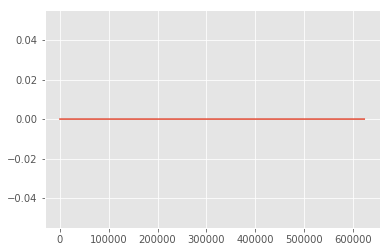

In [17]:
def get_info(fname):
    fname_record = total.query('fname == @fname')
    noisy_flg = fname_record["noisy_flg"].values[0]
    test_flg = fname_record["test_flg"].values[0]

    if test_flg == 1:
        wav_dir = data_dir + 'test/'
    else:
        if noisy_flg == 0:
            wav_dir = data_dir + 'train_curated/'
        else:
            wav_dir = data_dir + 'train_noisy/'

    print(fname)
    print(wav_dir)
    display(fname_record)
    
    rate, data = wavfile.read(wav_dir + fname)
    plt.plot(data)
    plt.show()
    
get_info('1d44b0bd.wav')

### train_noisy

In [18]:
train_noisy.query("wav_data_std == 0")

,fname,labels,nframe,wav_data_std
244,02f274b2.wav,"Stream,Trickle_and_dribble",661500,0.0
665,08b34136.wav,Race_car_and_auto_racing,661500,0.0
2086,1af3bd88.wav,"Car_passing_by,Bus,Race_car_and_auto_racing",661500,0.0
2460,1fd4f275.wav,Bus,661500,0.0
3701,2f503375.wav,"Fill_(with_liquid),Water_tap_and_faucet,Drip,S...",661500,0.0
4101,3496256e.wav,Motorcycle,661500,0.0
6625,551a4b3b.wav,Chirp_and_tweet,661500,0.0
7026,5a5761c9.wav,Bus,661500,0.0
8500,6d062e59.wav,Bus,661500,0.0
9217,769d131d.wav,Race_car_and_auto_racing,661500,0.0


In [19]:
silent_wav_list = train_noisy.query("wav_data_std == 0").fname.tolist()
len(silent_wav_list)

19

02f274b2.wav
../data/input/train_noisy/


,fname,labels,nframe,wav_data_std,noisy_flg,n_labels,test_flg
5214,02f274b2.wav,"Stream,Trickle_and_dribble",661500,0.0,1.0,2.0,0


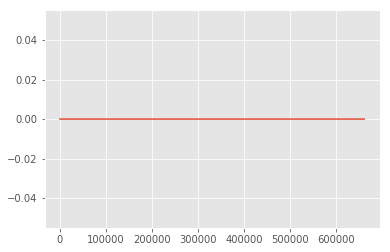

08b34136.wav
../data/input/train_noisy/


,fname,labels,nframe,wav_data_std,noisy_flg,n_labels,test_flg
5635,08b34136.wav,Race_car_and_auto_racing,661500,0.0,1.0,1.0,0


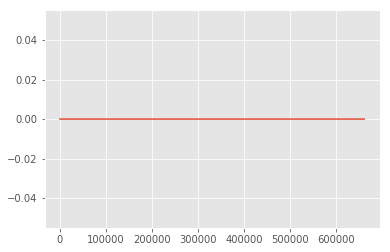

1af3bd88.wav
../data/input/train_noisy/


,fname,labels,nframe,wav_data_std,noisy_flg,n_labels,test_flg
7056,1af3bd88.wav,"Car_passing_by,Bus,Race_car_and_auto_racing",661500,0.0,1.0,3.0,0


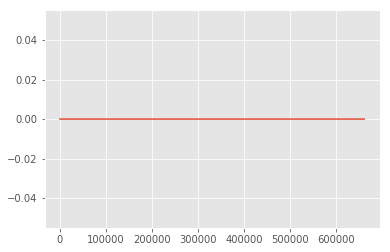

1fd4f275.wav
../data/input/train_noisy/


,fname,labels,nframe,wav_data_std,noisy_flg,n_labels,test_flg
7430,1fd4f275.wav,Bus,661500,0.0,1.0,1.0,0


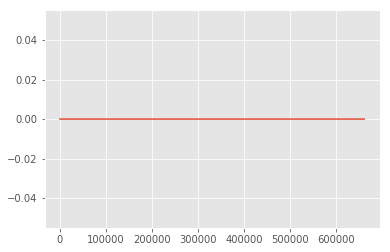

2f503375.wav
../data/input/train_noisy/


,fname,labels,nframe,wav_data_std,noisy_flg,n_labels,test_flg
8671,2f503375.wav,"Fill_(with_liquid),Water_tap_and_faucet,Drip,S...",661500,0.0,1.0,5.0,0


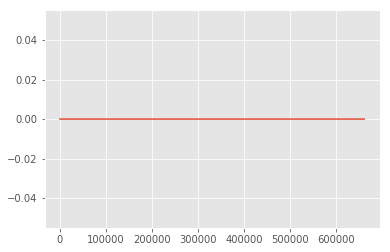

3496256e.wav
../data/input/train_noisy/


,fname,labels,nframe,wav_data_std,noisy_flg,n_labels,test_flg
9071,3496256e.wav,Motorcycle,661500,0.0,1.0,1.0,0


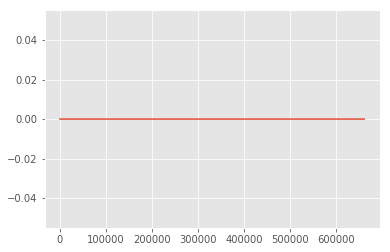

551a4b3b.wav
../data/input/train_noisy/


,fname,labels,nframe,wav_data_std,noisy_flg,n_labels,test_flg
11595,551a4b3b.wav,Chirp_and_tweet,661500,0.0,1.0,1.0,0


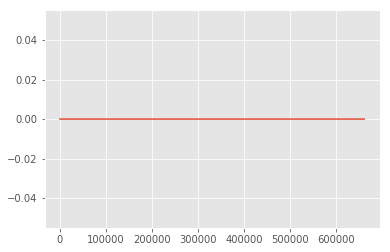

5a5761c9.wav
../data/input/train_noisy/


,fname,labels,nframe,wav_data_std,noisy_flg,n_labels,test_flg
11996,5a5761c9.wav,Bus,661500,0.0,1.0,1.0,0


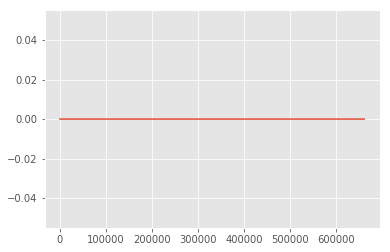

6d062e59.wav
../data/input/train_noisy/


,fname,labels,nframe,wav_data_std,noisy_flg,n_labels,test_flg
13470,6d062e59.wav,Bus,661500,0.0,1.0,1.0,0


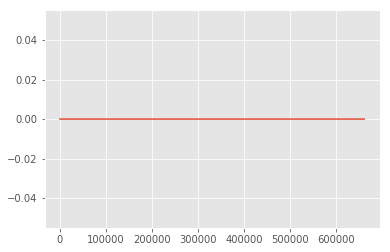

769d131d.wav
../data/input/train_noisy/


,fname,labels,nframe,wav_data_std,noisy_flg,n_labels,test_flg
14187,769d131d.wav,Race_car_and_auto_racing,661500,0.0,1.0,1.0,0


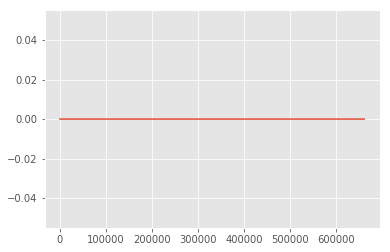

8c712129.wav
../data/input/train_noisy/


,fname,labels,nframe,wav_data_std,noisy_flg,n_labels,test_flg
15864,8c712129.wav,"Keys_jangling,Printer,Scissors",661500,0.0,1.0,3.0,0


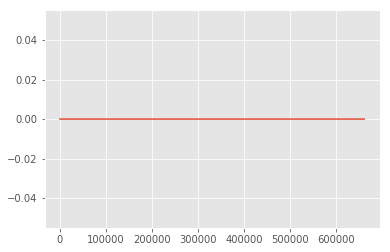

988cf8f2.wav
../data/input/train_noisy/


,fname,labels,nframe,wav_data_std,noisy_flg,n_labels,test_flg
16816,988cf8f2.wav,Race_car_and_auto_racing,661500,0.0,1.0,1.0,0


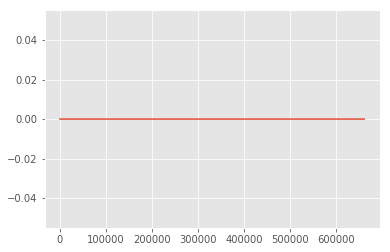

9f4fa2df.wav
../data/input/train_noisy/


,fname,labels,nframe,wav_data_std,noisy_flg,n_labels,test_flg
17370,9f4fa2df.wav,Car_passing_by,661500,0.0,1.0,1.0,0


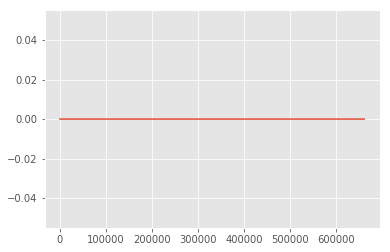

b1d2590c.wav
../data/input/train_noisy/


,fname,labels,nframe,wav_data_std,noisy_flg,n_labels,test_flg
18798,b1d2590c.wav,Bus,661500,0.0,1.0,1.0,0


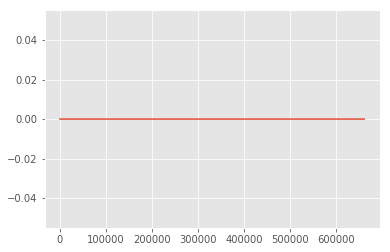

be273a3c.wav
../data/input/train_noisy/


,fname,labels,nframe,wav_data_std,noisy_flg,n_labels,test_flg
19763,be273a3c.wav,Race_car_and_auto_racing,661500,0.0,1.0,1.0,0


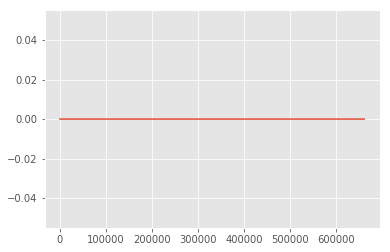

d527dcf0.wav
../data/input/train_noisy/


,fname,labels,nframe,wav_data_std,noisy_flg,n_labels,test_flg
21456,d527dcf0.wav,Zipper_(clothing),661500,0.0,1.0,1.0,0


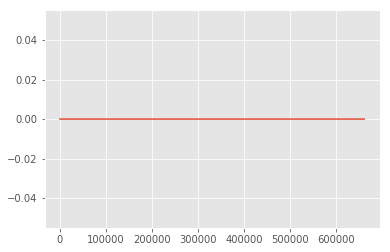

e4faa2e1.wav
../data/input/train_noisy/


,fname,labels,nframe,wav_data_std,noisy_flg,n_labels,test_flg
22726,e4faa2e1.wav,Motorcycle,661500,0.0,1.0,1.0,0


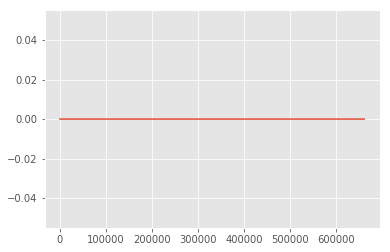

fa659a71.wav
../data/input/train_noisy/


,fname,labels,nframe,wav_data_std,noisy_flg,n_labels,test_flg
24371,fa659a71.wav,Bus,661500,0.0,1.0,1.0,0


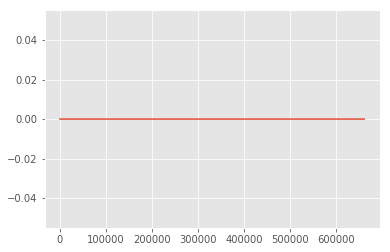

fba392d8.wav
../data/input/train_noisy/


,fname,labels,nframe,wav_data_std,noisy_flg,n_labels,test_flg
24481,fba392d8.wav,Church_bell,661500,0.0,1.0,1.0,0


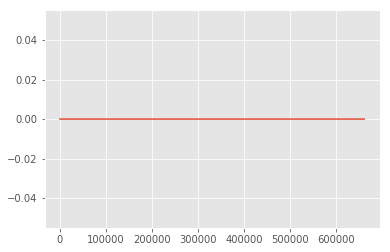

In [20]:
for fname in silent_wav_list:
    get_info(fname)

### test

In [21]:
test.query("wav_data_std == 0")

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing),nframe,wav_data_std


### summary

In [22]:
silent_wav_list = [
    '1d44b0bd.wav',
    '02f274b2.wav',
    '08b34136.wav',
    '1af3bd88.wav',
    '1fd4f275.wav',
    '2f503375.wav',
    '3496256e.wav',
    '551a4b3b.wav',
    '5a5761c9.wav',
    '6d062e59.wav',
    '769d131d.wav',
    '8c712129.wav',
    '988cf8f2.wav',
    '9f4fa2df.wav',
    'b1d2590c.wav',
    'be273a3c.wav',
    'd527dcf0.wav',
    'e4faa2e1.wav',
    'fa659a71.wav',
    'fba392d8.wav'    
]
len(silent_wav_list), len(list(set(silent_wav_list)))

(20, 20)